# Examen Argumentativo 2: Práctico
## Uso de Geometría y Topología para Ciencia de Datos
### Christian Jaffé Alarcón Acosta A00832881

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kmapper as km
import sklearn
from IPython.display import display, HTML
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
import umap
import umap.plot

Lo que corresponde hacer ahora es buscar grupos de vinos que compartan características e identificar si realmente hay una relación entre estas caracteríticas con el tipo de vino y así poder determinar su calidad.
 
Para atacar esta problemática se realizarán inicialmente procesos de ML y  posteriormente con TDA para analizar los resultados obtenidos y validar las diferencias entre ellos para así encontrar nuevos hallazgos.

## Exploratory Data Analysis

Inicialmente se sabe que la base de datos está compuesta de características de tres diferentes tipos de vinos, sin embargo, estos no se encuentran clasificados dentro de la base de datos.

In [2]:
data = pd.read_csv('wine-clustering.csv') #Se lee la base de datos y se despliega la dimensión y las primeras 5 filas
print('Dimensión: ', data.shape)
data.head(5)

Dimensión:  (178, 13)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Se puede observar que el dataset tiene una dimensión de 178 filas y 13 columnas, que nos representan 13 características distintas 178 tipos de vinos

In [3]:
print(f'Valores faltantes: {data.isna().sum().sum()}')
print('')
print(f'Valores duplicados: {data.duplicated().sum()}, ({np.round(100*data.duplicated().sum()/len(data),1)}%)')
print('')
print(f'Tipos de  datos: {data.dtypes.unique()}')

Valores faltantes: 0

Valores duplicados: 0, (0.0%)

Tipos de  datos: [dtype('float64') dtype('int64')]


### Detección de Outliers

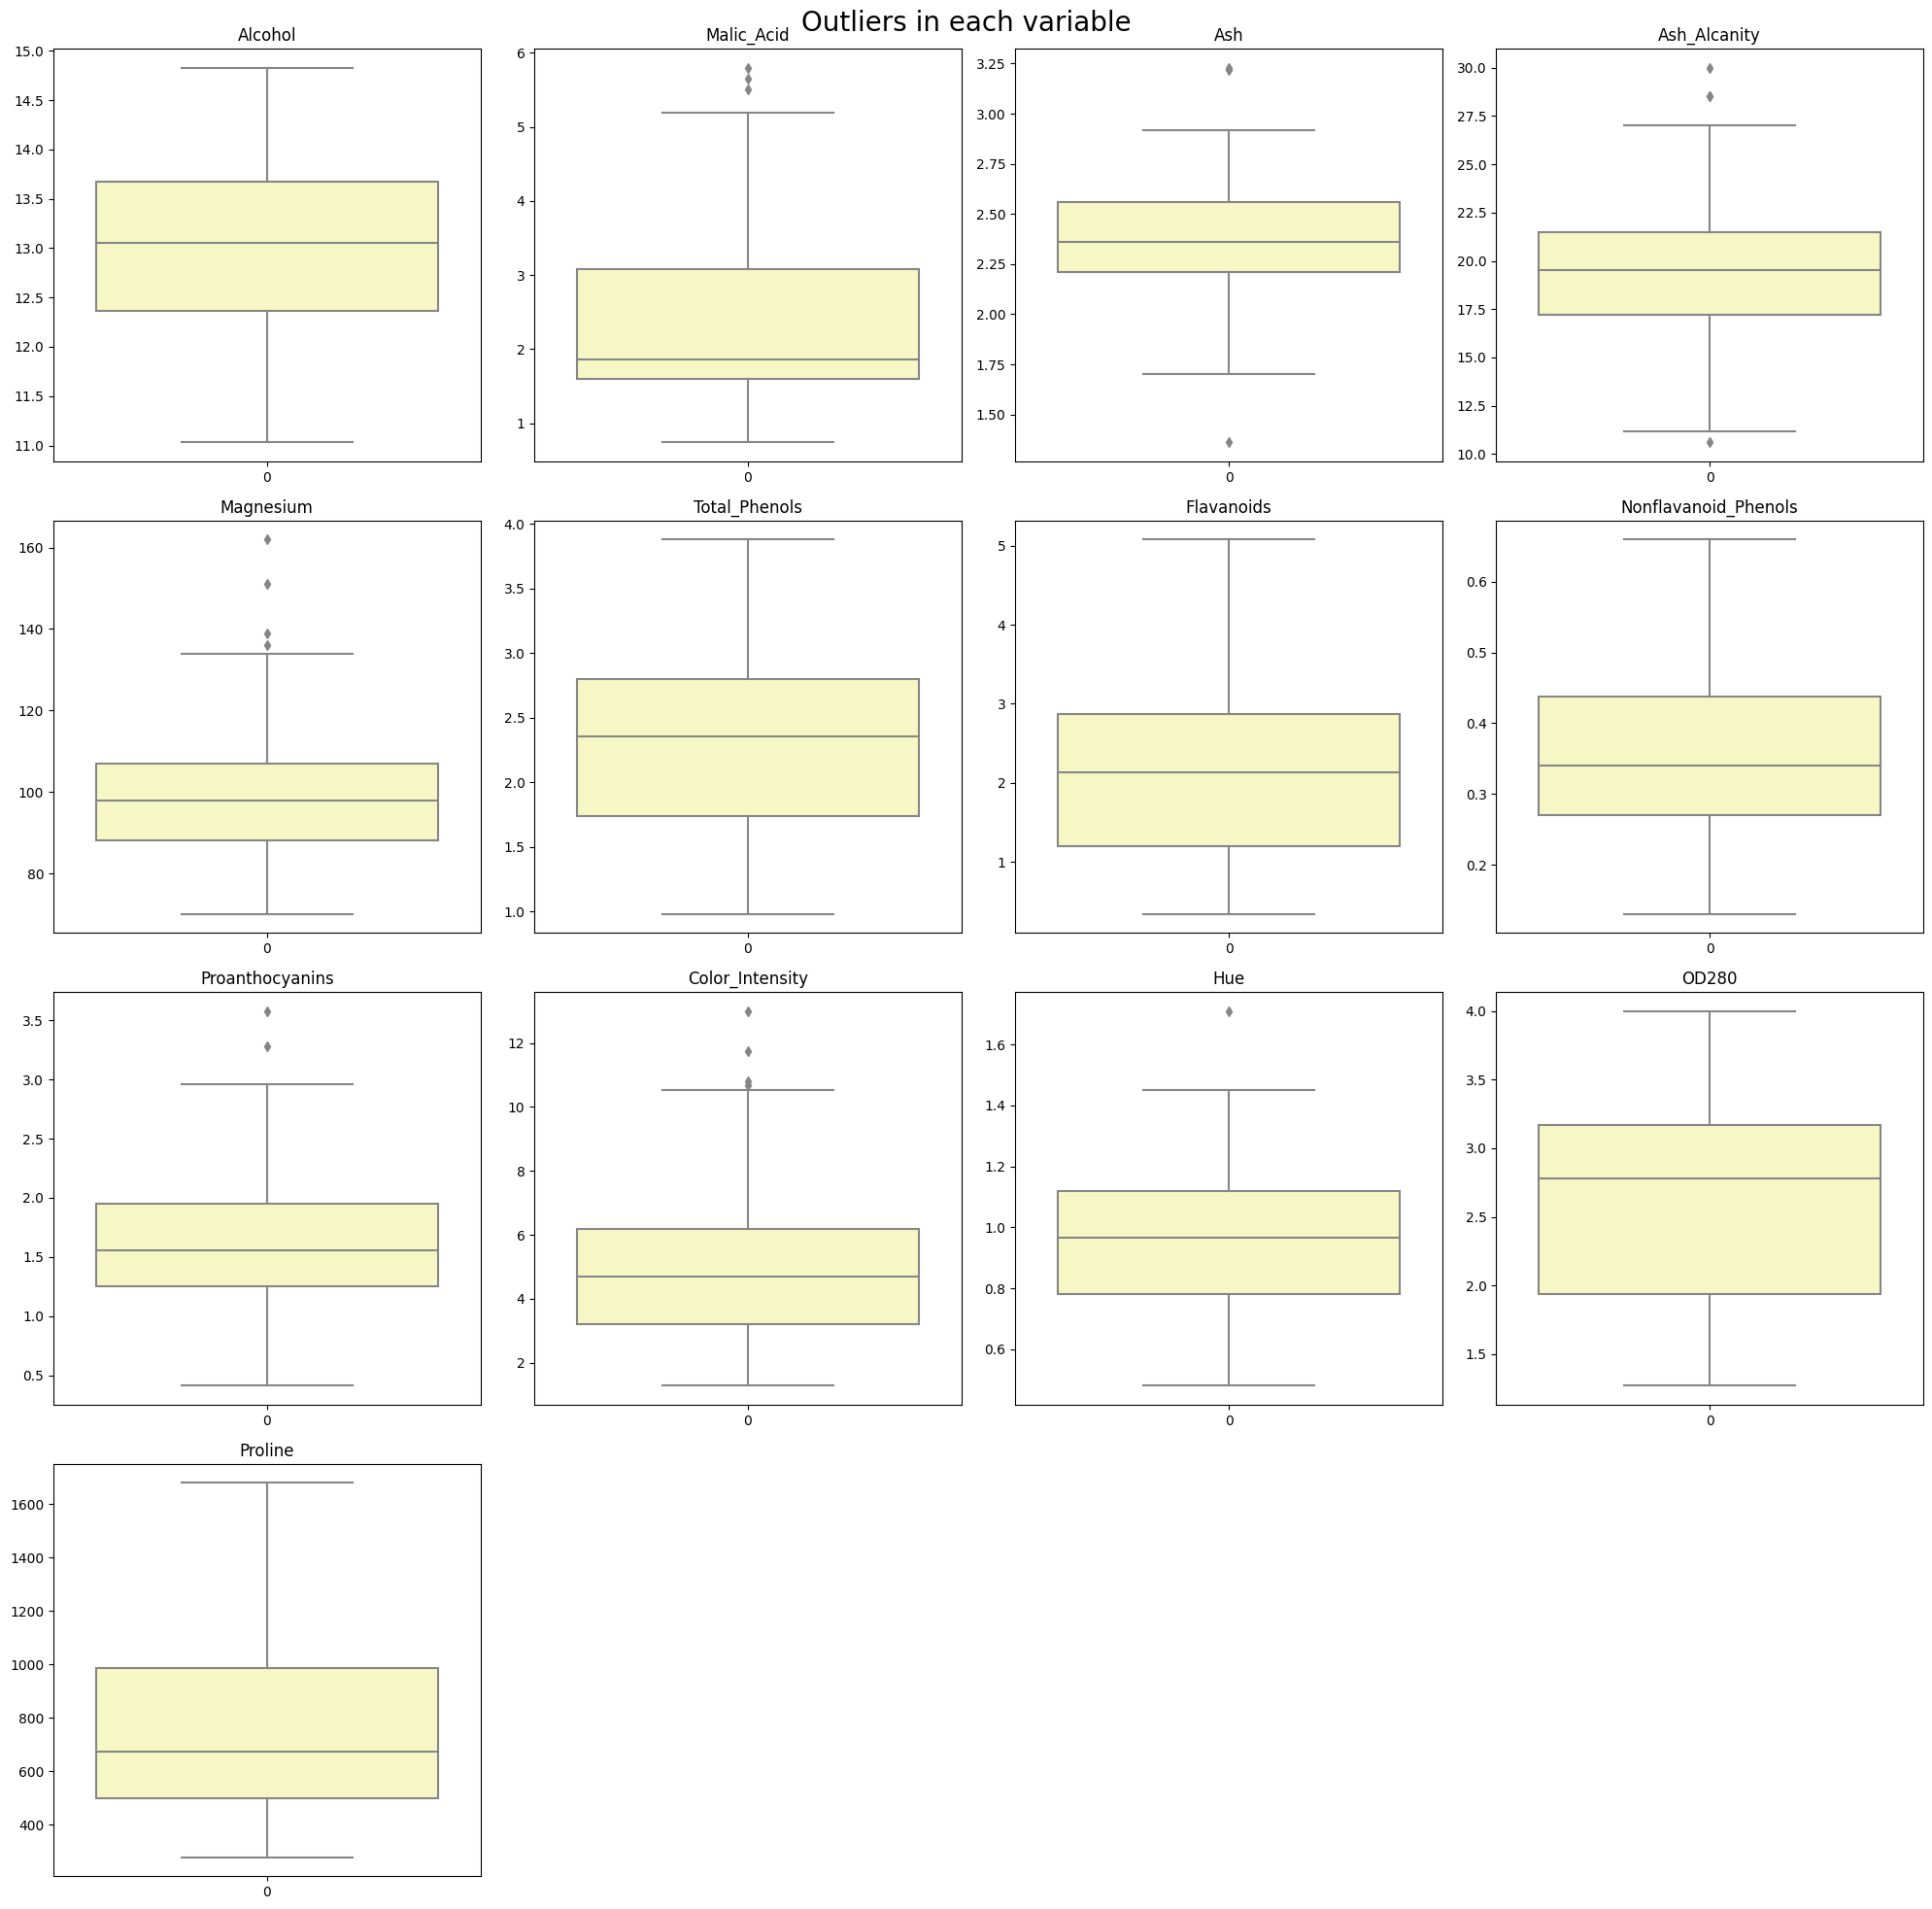

In [4]:
#Características del dataframe
num_columns = len(data.columns)
nrows = (num_columns // 4) + (1 if num_columns % 4 > 0 else 0)  # Calcula cuántas filas necesitas
ncols = 4

#Se crea el subplot
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5))
fig.suptitle('Outliers in each variable', size=20)


for i, col in enumerate(data.columns):
    ax = axes[i // ncols, i % ncols]  # Determina la posición del subplot
    sns.boxplot(ax=ax, data=data[col], palette='Spectral').set_title(col)


# Oculta los axes que no se usen
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j // ncols, j % ncols])

plt.tight_layout()
plt.show()


Al hacer una detección de outliers, se puede observar que variables como 'Malic_Acid', 'Ash', 'Ash_alcalinity', 'Magnesium', 'Proanthocyanins', 'Color_intensity' y'Hue' presentan outliers de acuerdo al IQR, por lo que por este mismo método procederemos a eliminarlos.

In [5]:
#Función para identificar y eliminar outliers
def remove_outliers(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Solo conservar las filas que no son outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

data_clean = remove_outliers(data)
data_clean.shape

(161, 13)

Se puede observar que no hubo una pérdida significativa de datos al eliminar los outliers, por lo que se usará el dataset sin outliers.

# Método: PCA y K-Means

En este caso como queremos utilizar todo las variables del dataframe para realizar la clusterización, inicialmente se hará un PCA para reeducir dimensionalidad uy posteriormente se aplicará K-Means.

### Normalización de la data

In [6]:
data_kmeans = data_clean #Nombramos un df para utilizar con PCA y kmeans
#Normalizamos la data
scaler = StandardScaler()
data_normalized_pca=pd.DataFrame(scaler.fit_transform(data_kmeans), columns=data_clean.columns) 

### Número óptimo de clusters

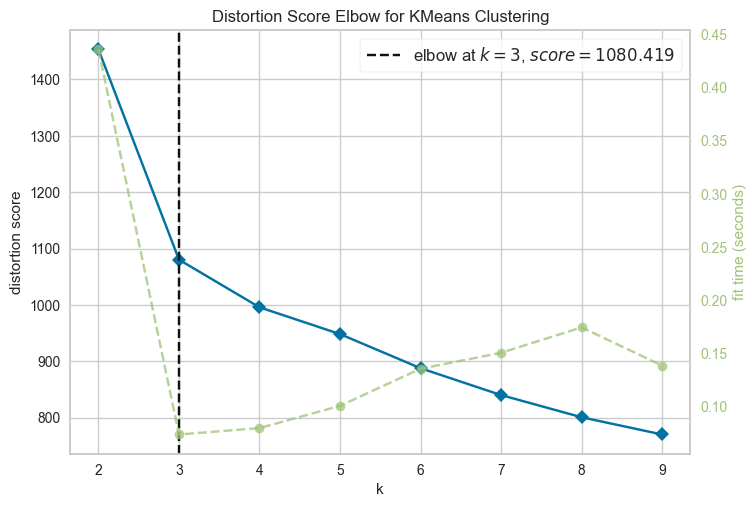

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
#Número óptimo de clusters
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(data_normalized_pca)
visualizer.show()

Apoyándonos con kmeans, que es un método que requiere que le indiques el número de clusters, se puede observar que recomienda un número de 3 clusters, que coincide con la información de nuestro dataset, correspondiente a 3 tipos de vinos

In [8]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 y 3 dimensiones para visualización
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

data_2d = pca_2d.fit_transform(data_normalized_pca)
data_3d = pca_3d.fit_transform(data_normalized_pca)


In [9]:
from sklearn.cluster import KMeans

# Definir el número de clusters
k = 3  # o usa el método del codo para encontrar el número óptimo

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_normalized_pca)

# Agregar las etiquetas de cluster al DataFrame original y a los componentes PCA
data_kmeans['Cluster'] = clusters


In [10]:
data_kmeans.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2


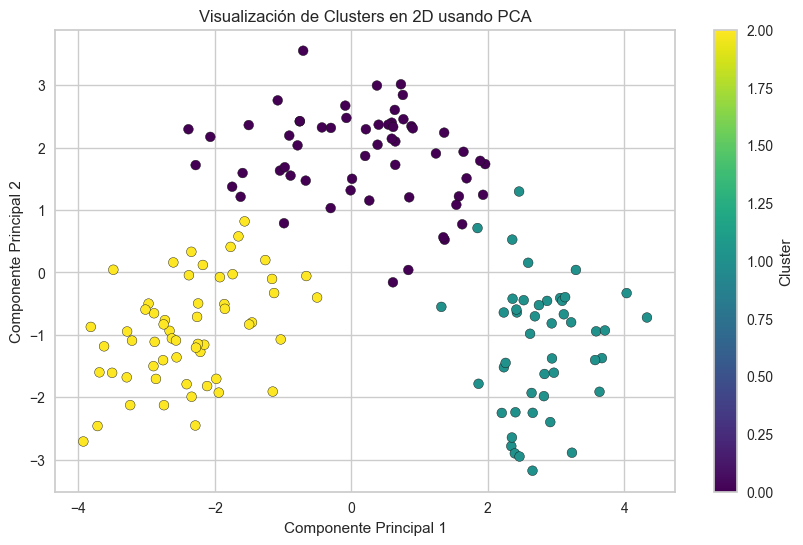

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title('Visualización de Clusters en 2D usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


In [12]:
import plotly.express as px
# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(data_normalized_pca)

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=clusters, size=0.1*np.ones(len(data_normalized_pca)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

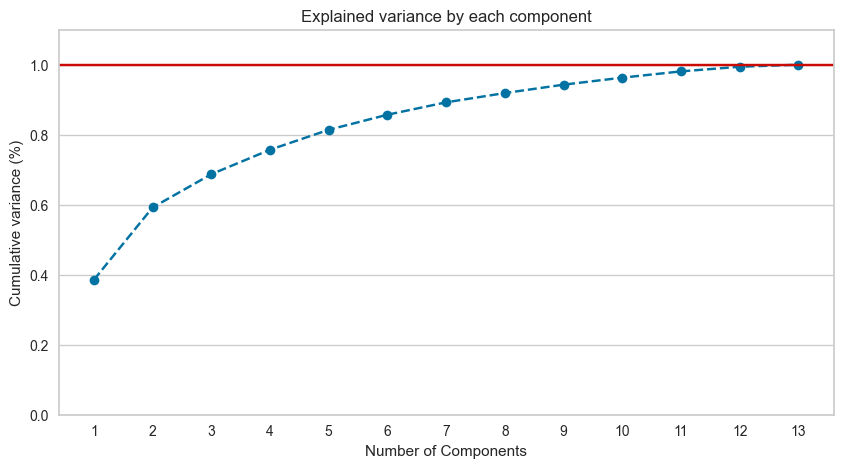

In [13]:
# PCA
pca_var = PCA()
pca_var.fit(data_normalized_pca)

# Plot
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+data_normalized_pca.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+data_normalized_pca.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

# UMAP

In [30]:
data_umap = data_clean
data_normalized_umap=pd.DataFrame(scaler.fit_transform(data_umap), columns=data_clean.columns) 

In [15]:
from umap.umap_ import UMAP

In [31]:
# UMAP
um = umap.UMAP()
X_fit = um.fit(data_normalized_umap)           # we'll use X_fit later
X_umap = um.transform(data_normalized_umap)

# Convert to data frame
umap_df = pd.DataFrame(data = X_umap, columns = ['umap comp. 1', 'umap comp. 2'])

# Shape and preview
print(umap_df.shape)
umap_df.head()

(161, 2)


,umap comp. 1,umap comp. 2
0,-17.631901,1.405449
1,-16.409733,1.084886
2,-16.175547,2.277853
3,-17.358095,2.439374
4,-15.291955,1.871605


Text(0, 0.5, 'umap component 2')

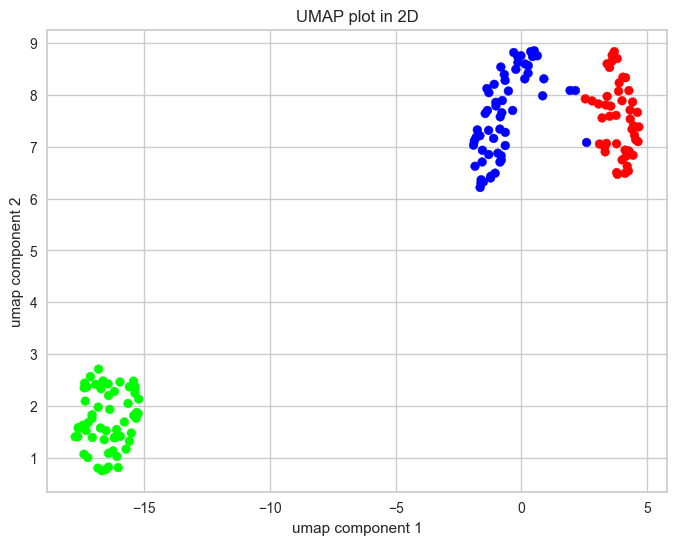

In [32]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
plt.scatter(umap_df.iloc[:,0], umap_df.iloc[:,1], c=clusters, cmap="brg", s=40)

## Centroids
#centroids_umap = um.transform(centroids)
#plt.scatter(x=centroids_umap[:,0], y=centroids_umap[:,1], marker="x", s=500, linewidths=3, color="black")

# Aesthetics
plt.title('UMAP plot in 2D')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')

In [22]:
# UMAP
um = umap.UMAP(n_components=3)
components_umap = um.fit_transform(data_normalized_umap)

# 3D scatterplot
fig = px.scatter_3d(
    components_umap, x=0, y=1, z=2, color=clusters, size=0.1*np.ones(len(data_normalized_umap)), opacity = 1,
    title='UMAP plot in 3D',
    labels={'0': 'comp. 1', '1': 'comp. 2', '2': 'comp. 3'},
    width=650, height=500
)
fig.show()

<AxesSubplot: >

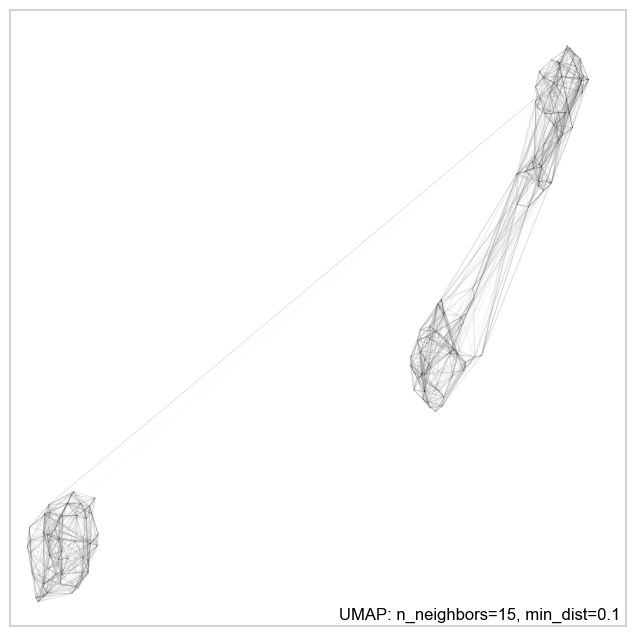

In [23]:
# Connectivity plot
umap.plot.connectivity(X_fit, show_points=True)

<AxesSubplot: >

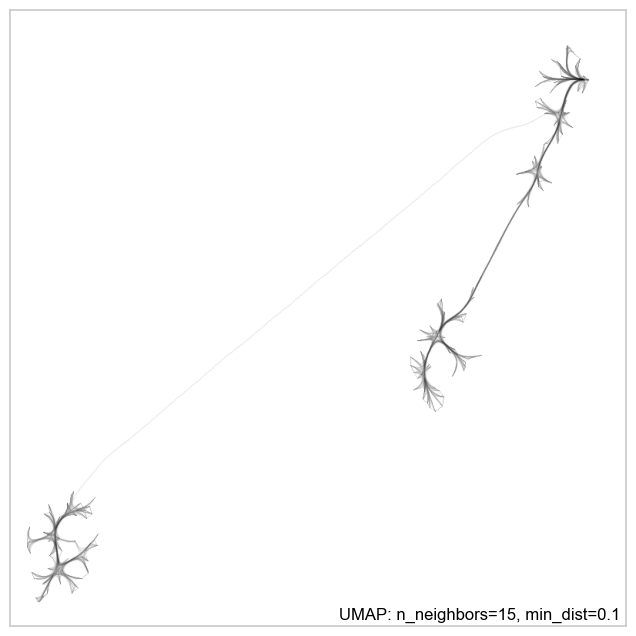

In [25]:
# Bundling can provide a simplified view of the connections
umap.plot.connectivity(X_fit, show_points=True, edge_bundling='hammer')

# Mapper

In [34]:
data_mapper = data.to_numpy()
data_normalized_mapper= scaler.fit_transform(data_mapper)

In [ ]:
data.head()

In [37]:
mapper = km.KeplerMapper(verbose=1)
# La proyección sobre el math score, corresponde a proyectar sobre la primera columna de data
projected_data = mapper.fit_transform(data_normalized_mapper, projection=[0,1,2,3,4,5,6,7,8,9,10,11,12], scaler=None) 

covering=km.Cover(n_cubes=10,perc_overlap=0.08)

import warnings

# Ignorar todas las advertencias
warnings.filterwarnings('ignore')

G = mapper.map(projected_data, data, clusterer=sklearn.cluster.KMeans(n_clusters=3),cover=covering)

mapper.visualize(G, 
                path_html="mapper_visualization_output.html",
                 title="Mapper on Wine Data",
                #custom_tooltips = performance_data['gender'].to_numpy(),
                #color_values = mean,
                #color_function_name = 'Mean of Reading and Writing Score',
                node_color_function=np.array(['average','std','sum','max','min']))

#display(HTML('performance_math_score.html'))

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (178, 13)

..Projecting data using: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Mapping on data shaped (178, 13) using lens shaped (178, 13)

